In [ ]:
from jax.numpy.fft import rfft as fft, rfftfreq as fftfreq, irfft as ifft
import jax
jax.config.update("jax_enable_x64", True)


import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import jit


In [ ]:
#Initial Conditions
j = jnp.imag
L = 22
T = 25*2
nx = 128
dx = L/nx
levels = jnp.linspace(-2.5, 2.5, 300)
nt = 200*2
dt = T/nt
x = jnp.linspace(0, L, nx)
v = 1

#Initial Conditions

u0 = 1 * np.cos(2 * np.pi * x / L) + .5 * np.sin(2 * np.pi * x / L) + .3 * np.cos(4 * np.pi * x / L) + .1 * np.sin(4 * np.pi * x / L)

In [ ]:
@jit
def u_plus_period(u_plus_time, nt=nt):
  u = u_plus_time[0:-1]
  T = u_plus_time[-1]
  #nt =  1000
  dt = T/nt                              #Takes in New u value from Adjoint looping or Newton Krylov, and iterates through time to find its corresponding value period T away
  u_hat = fft(u)
  u_hat_2 = fft(u**2)
  u_hat_2_neg = fft(u**2)
  u_former = u
  k = 2*jnp.pi/L*fftfreq(nx)*nx

  F_Linear = k**2 - v*k**4

  F_NonLinear = -.5*1j*k*dt/nx

  CN_Right = (1 + dt/2*F_Linear)/nx
  CN_Left_Inverse = 1/(1-dt/2*F_Linear)*nx

  def Time_Step(i, state):                              #iterates the function u forward in time by dt
    u, u_hat, u_hat_2, u_hat_2_neg = state
    u_plus_hat = CN_Left_Inverse*(CN_Right*u_hat + 1.5*F_NonLinear * u_hat_2 - .5*F_NonLinear*u_hat_2_neg) #recursion formula which generates the next time step u_plus
    u_plus = ifft(u_plus_hat)                           #converting back to normal units
    state = u_plus, u_plus_hat, fft(u_plus**2), u_hat_2
    return state

  initial_state = u, u_hat, u_hat_2, u_hat_2_neg
  final_state   = jax.lax.fori_loop(0, nt-1, Time_Step, initial_state)

  u_final = Time_Step(0,final_state)

  dudt    = (Time_Step(0,u_final)[0] - final_state[0])/(2*dt)

  return u_final[0], dudt


NameError: name 'jit' is not defined

In [ ]:

'''#Autocorrelation Plot
net_u = []
net_u.append(u0)
for i in range(nt):
  net_u.append(u_plus_period(jnp.append(u0,jnp.array([dt*i])))[0])

residual_array = np.zeros((nt, nt))
for i in range(nt):
  for j in range(nt):
    b = net_u[int(i)] - net_u[int(j)]
    residual_array[i,j] = np.linalg.norm(b, 2)

#PLOT AUTOCORROLATION PLOT
fig, ax = plt.subplots(figsize=(10,10))
x = np.linspace(0, nt, nt)
y = np.linspace(0, nt, nt)
xx, tt = np.meshgrid(x, y)
levels = np.linspace(-3.5, 3.5, 300)
cs = ax.contourf(xx, tt, residual_array)
fig.colorbar(cs)
ax.set_xlabel("t1")
ax.set_ylabel("t2")
ax.set_title("AUTOCORROLATION PLOT")
'''

'#Autocorrelation Plot\nnet_u = []\nnet_u.append(u0)\nfor i in range(nt):\n  net_u.append(u_plus_period(jnp.append(u0,jnp.array([dt*i])))[0])\n\nresidual_array = np.zeros((nt, nt))\nfor i in range(nt):\n  for j in range(nt):\n    b = net_u[int(i)] - net_u[int(j)]\n    residual_array[i,j] = np.linalg.norm(b, 2)\n\n#PLOT AUTOCORROLATION PLOT\nfig, ax = plt.subplots(figsize=(10,10))\nx = np.linspace(0, nt, nt)\ny = np.linspace(0, nt, nt)\nxx, tt = np.meshgrid(x, y)\nlevels = np.linspace(-3.5, 3.5, 300)\ncs = ax.contourf(xx, tt, residual_array)\nfig.colorbar(cs)\nax.set_xlabel("t1")\nax.set_ylabel("t2")\nax.set_title("AUTOCORROLATION PLOT")\n'

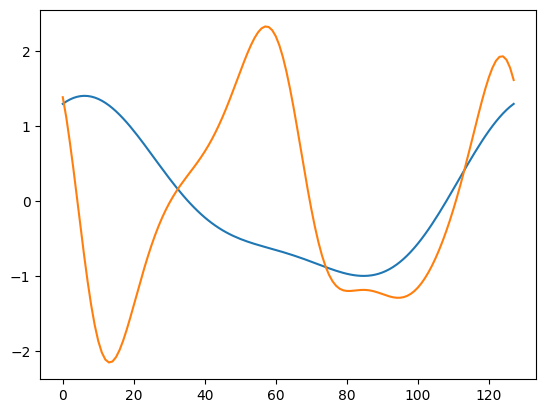

In [ ]:
'''
#Finds Best Guess for where RPO will be
t1_min = 0
t2_min = 0
min_val = 100
for i in range(nt):
  for j in range(nt):
    if np.abs(i-j) >= nt/4:
      if residual_array[i][j] < min_val:
        t1_min = int(i)
        t2_min = int(j)
        min_val = residual_array[i][j]

print(t1_min)
print(t2_min)
print(residual_array[int(t1_min)][int(t2_min)])

#u = jnp.append(net_u[t1_min],jnp.array([(t2_min-t1_min)/nt*T]))
'''
u = jnp.append(u0, jnp.array(T/3))
plt.plot(u[:-1])
plt.plot(u_plus_period(u)[0])


In [ ]:
#ADJOINT LOOPING

def loss(u_plus_time):
  u_val = u[0:-1]
  res = u_val - u_plus_period(u_plus_time)[0]
  return jnp.linalg.norm(res)#jnp.dot(res,res)

@jit
def Adjoint_Looping(t, u_plus_time):
  du_ds = -jax.grad(loss)(u_plus_time)
  du_ds = (du_ds.at[-1]).set(du_ds[-1])
  return du_ds

def Step(du, du_prev):
  step_size = .005 #Initial Step size (can calibrate)
  return step_size*jnp.linalg.norm(du_prev)/(jnp.linalg.norm(du) + 1e-8) #1e-8 prevents divide by 0 error.

#@jit
#def Adam_Step2(du, du_prev):
#  h = .01
#  return h*(3/2*du - 1/2*du_prev)

#def Adam_Step3(du, du_prev, du_pprev):
#  h = .005
#  return h*(23/12*du - 16/12*du_prev + 5/12*du_pprev)

In [ ]:
@jax.jit
def loss_and_grad(x):
  u, T = x, x[-1]

  L = lambda u: jnp.linalg.norm((u_plus_period(u)[0] - u[:-1]))
  loss, grad = jax.value_and_grad(L)(u)
  u_T, dudt = u_plus_period(u)
  grad = grad.at[-1].set(jnp.sum( dudt * (u_T - u[:-1])))


  return loss, grad


In [ ]:
def Adam(x0, steps=2500, a=0.05, b1=0.9, b2=0.999, eps = 1e-8):

  def grad_step(state, drop):
    x, m, v, t = state

    loss_val, g = loss_and_grad(x)

    m = b1 * m + (1 - b1) * g
    v = b2 * v + (1 - b2) * (g ** 2)

    bm, bv = (1 - b1 ** t), (1 - b2 ** t)

    x -= a * (m / bm) / (jnp.sqrt(v/bv) + eps)

    return (x, m, v, t + 1), (loss_val, x)

  return jax.lax.scan(grad_step, (x0, x0*0, x0*0, 1), None, length=steps)[1]

In [ ]:
loss_adam, U = Adam(u, steps = 4000, a = 0.001)
plt.plot(loss_adam)
u = U[-1]

NameError: name 'Adam' is not defined

Step works better than RK45

Step works better than Adam_Step2

In [ ]:
import scipy
residuals = []
period = []
shift = []
'''


y_loss_prev = 0
#RK = scipy.integrate.RK45(Adjoint_Looping, 0, u, 1e7, rtol=1e-6, atol=1e-9)
i = 1
du_prev = Adjoint_Looping(0, u)
du_pprev = Adjoint_Looping(0, u)
while(True):
  #RK.step()
  #u_intermediate = RK.y
  du = Adjoint_Looping(0, u)
  #print(du)
  #step_size = Step(du, du_prev)
  du_hold = du
  u += du*Step(du, du_prev)
  #u += Adam_Step2(du, du_prev)
  #u += Adam_Step3(du, du_prev, du_pprev)

  #if(i > 1):
  #  du_pprev = du_prev
  du_prev = du_hold

  u_intermediate = u
  l = loss(u_intermediate)
  print(f"Step {i}")
  print(f"Residual: {l}")
  residuals.append(l)
  period.append(u_intermediate[-1])
  print(f"Period: {u_intermediate[-1]}\n")
  i += 1
  if(abs(loss(u_intermediate) - y_loss_prev) < .00001):
    break;
  y_loss_prev = loss(u_intermediate)
#u = RK.y
print(loss(u))
print(u)
plt.plot(residuals)
'''

'\n\n\ny_loss_prev = 0\n#RK = scipy.integrate.RK45(Adjoint_Looping, 0, u, 1e7, rtol=1e-6, atol=1e-9)\ni = 1\ndu_prev = Adjoint_Looping(0, u)\ndu_pprev = Adjoint_Looping(0, u)\nwhile(True):\n  #RK.step()\n  #u_intermediate = RK.y\n  du = Adjoint_Looping(0, u)\n  #print(du)\n  #step_size = Step(du, du_prev)\n  du_hold = du\n  u += du*Step(du, du_prev)\n  #u += Adam_Step2(du, du_prev)\n  #u += Adam_Step3(du, du_prev, du_pprev)\n\n  #if(i > 1):\n  #  du_pprev = du_prev\n  du_prev = du_hold\n\n  u_intermediate = u\n  l = loss(u_intermediate)\n  print(f"Step {i}")\n  print(f"Residual: {l}")\n  residuals.append(l)\n  period.append(u_intermediate[-1])\n  print(f"Period: {u_intermediate[-1]}\n")\n  i += 1\n  if(abs(loss(u_intermediate) - y_loss_prev) < .00001):\n    break;\n  y_loss_prev = loss(u_intermediate)\n#u = RK.y\nprint(loss(u))\nprint(u)\nplt.plot(residuals)\n'

Interesting Property where a coaser grid for adjoint is quicker but a finer grid for newton is quicker!

In [ ]:
@jit
def u_plus_period(u_plus_time):
  u = u_plus_time[0:-1]
  T = u_plus_time[-1]
  nt =  1000
  dt = T/nt                              #Takes in New u value from Adjoint looping or Newton Krylov, and iterates through time to find its corresponding value period T away
  u_hat = fft(u)
  u_hat_2 = fft(u**2)
  u_hat_2_neg = fft(u**2)
  u_former = u
  k = 2*jnp.pi/L*fftfreq(nx)*nx

  F_Linear = k**2 - v*k**4

  F_NonLinear = -.5*1j*k*dt/nx

  CN_Right = (1 + dt/2*F_Linear)/nx
  CN_Left_Inverse = 1/(1-dt/2*F_Linear)*nx

  def Time_Step(i, state):                              #iterates the function u forward in time by dt
    u, u_hat, u_hat_2, u_hat_2_neg = state
    u_plus_hat = CN_Left_Inverse*(CN_Right*u_hat + 1.5*F_NonLinear * u_hat_2 - .5*F_NonLinear*u_hat_2_neg) #recursion formula which generates the next time step u_plus
    u_plus = ifft(u_plus_hat)                           #converting back to normal units
    state = u_plus, u_plus_hat, fft(u_plus**2), u_hat_2
    return state

  initial_state = u, u_hat, u_hat_2, u_hat_2_neg
  final_state   = jax.lax.fori_loop(0, nt-1, Time_Step, initial_state)

  u_final = Time_Step(0,final_state)
  #dudt_hat = F_Linear * u_hat
  #dudt = ifft(dudt_hat)
  dudt    = (Time_Step(0,u_final)[0] - final_state[0])/(2*dt)


  return u_final[0], dudt


[ 7.84267524e-01  7.74089017e-01  7.56121694e-01  7.30807644e-01
  6.98746455e-01  6.60969693e-01  6.18687528e-01  5.73474999e-01
  5.27045463e-01  4.81353020e-01  4.38393138e-01  4.00238028e-01
  3.68871174e-01  3.46240679e-01  3.33872363e-01  3.33230123e-01
  3.45366022e-01  3.70961320e-01  4.10248433e-01  4.63013009e-01
  5.28527823e-01  6.05567343e-01  6.92356177e-01  7.86595202e-01
  8.85430283e-01  9.85502300e-01  1.08295321e+00  1.17352639e+00
  1.25263682e+00  1.31555347e+00  1.35755555e+00  1.37421286e+00
  1.36161899e+00  1.31674163e+00  1.23766578e+00  1.12392676e+00
  9.76636449e-01  7.98675861e-01  5.94563621e-01  3.70417863e-01
  1.33501469e-01 -1.08032543e-01 -3.45830369e-01 -5.71682701e-01
 -7.78220977e-01 -9.59180536e-01 -1.10987169e+00 -1.22723047e+00
 -1.30996688e+00 -1.35838268e+00 -1.37425574e+00 -1.36051093e+00
 -1.32097991e+00 -1.26004858e+00 -1.18242162e+00 -1.09283662e+00
 -9.95903999e-01 -8.95918344e-01 -7.96785819e-01 -7.01917951e-01
 -6.14225928e-01 -5.36064

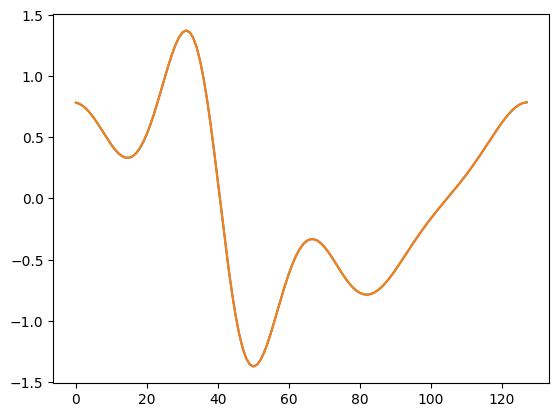

In [ ]:


#NEWTON
print(u)
@jit
def f(u):
    u_new, dudt = u_plus_period(u)
    res = jnp.abs(u_new - u[:-1])
    return jnp.append(res, jnp.array([0]))


def Jac(u0):
  uf, dudt = u_plus_period(u0)


  def J(v):
    dres_dv = jax.jvp(f, (u0,), (v,))[1]

    #dres_dv.at[:-1].set(dres_dv[:-1]*v[:-1])
    dudt_v = jnp.dot(dudt, v[:-1]) + v[-1]

    return dres_dv.at[-1].set(dudt_v)

  return jax.jit(J)


def Step_Size(du, u):

  base_stepsize = .01
  grad_mag = jnp.linalg.norm(du)
  max_step = base_stepsize*(1 + jnp.linalg.norm(u))
  if grad_mag > max_step:
    du = du * max_step / grad_mag
  return du

def Step(du, du_prev):
  step_size = .005 #Initial Step size (can calibrate)
  return step_size*jnp.linalg.norm(du_prev)/(jnp.linalg.norm(du) + 1e-8) #1e-8 prevents divide by 0 error.


'''
def HookStep(u, du):
  #Taking Inspiration from Paper: Recent Advances in Trust Region Algorithms Ya-xiang Yuan
  if(jnp.linalg.norm(du) > 10):
    du = du / jnp.linalg.norm(du)*10
  Actual_Reduction = jnp.linalg.norm(f(u)) - jnp.linalg.norm(f(u+du))

  Predicted_Reduction = jnp.linalg.norm(f(u)) - jnp.linalg.norm(f(u) + Jac(u)(du))
  ratio = Actual_Reduction/Predicted_Reduction
  if ratio < 0:
    du *= 1/ratio

  return du, ratio, Actual_Reduction, Predicted_Reduction

'''
#NEWTON
import math
i = 0
print(jnp.linalg.norm(f(u)))
#du_prev = jax.scipy.sparse.linalg.gmres(Jac(u), -f(u))[0]
while(True):
    du = jax.scipy.sparse.linalg.gmres(Jac(u), -f(u))[0]

   # du = du/jnp.linalg.norm(du)*min(loss(u+du), 1)
    residual_norm = jnp.linalg.norm(Jac(u)(du) + f(u))
    print(f"GMRES residual norm: {residual_norm}")
    print(f"Step Magnitude: {jnp.linalg.norm(du)}")
    du = Step_Size(du, u)
    #du_save = du
    #du = du*Step(du,du_prev)
    #du_prev = du_save

    #du, ratio, Actual_Reduction, Predicted_Reduction = HookStep(u, du)
    #print(f"Ratio of Actual Reduction / Predicted Reduction = {ratio}")
    #print(f"Actual Reduction = {Actual_Reduction}")
    #print(f"Predicted Reduction = {Predicted_Reduction}")
    #print(du)
    #du = du.at[-1].set(0)
    #while(loss(u) < loss(u+du)):
    #   du *= .8
    #while(loss(u+du) > loss(u+du*.8)):
    #   du *= .8
    u += du #There is a problem with the directional derivative
    plt.plot(u[:-1])
    res_loss = loss(u)#jnp.linalg.norm(f(u))
    print("Step ", i+1)
    print("Residual = ", res_loss)
    residuals.append(res_loss)
    print("Period = ", u[-1])
    print("\n")
    i += 1

    if(res_loss < 10**-10):
      break



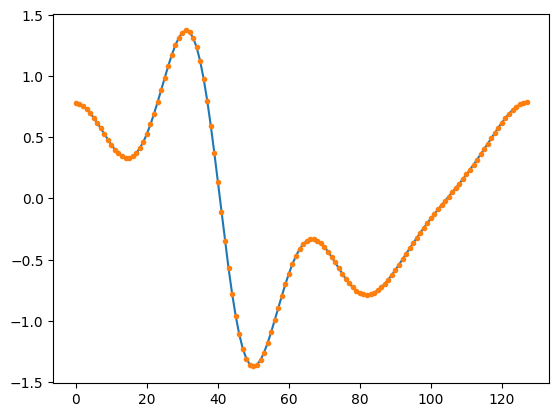

In [ ]:
plt.plot(u[0:-1])
plt.plot(u_plus_period(u)[0], '.')

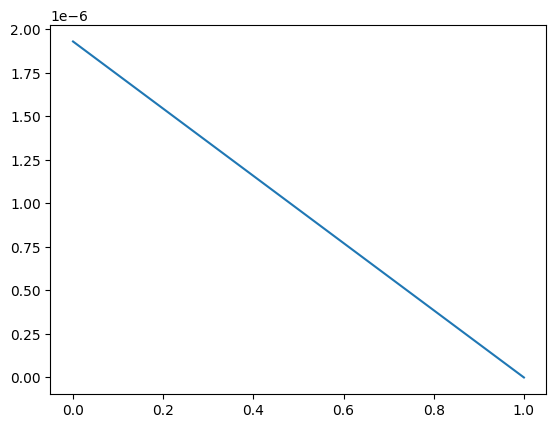

In [ ]:
plt.plot(residuals)

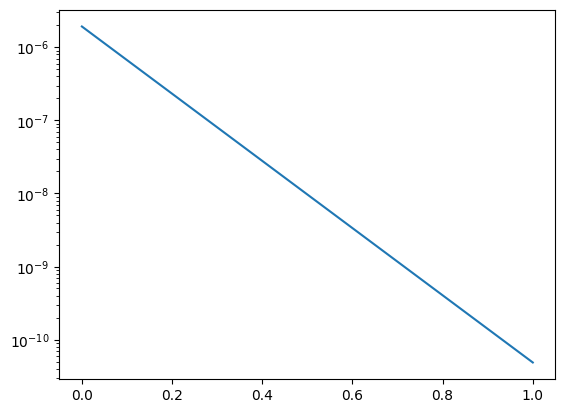

In [ ]:
plt.semilogy(residuals)

Modify Step Size method
un-jit the integrator or find way around adjoint loss

In [ ]:
import jax.numpy as jnp
import pandas as pd
from google.colab import files

# Example JAX array

# Convert the JAX array to a Pandas DataFrame
df = pd.DataFrame(u)

# Save the DataFrame as an Excel file
excel_filename = "PO 1.xlsx"
df.to_excel(excel_filename, index=False, header=False, engine='openpyxl')

# Download the Excel file to your local Downloads folder
files.download(excel_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>